## Head

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import datetime
import functools

from typing import List, Union, Optional, Dict

## Utils

In [8]:
def dask_groupby(
    data: dd.DataFrame,
    by: List[str],
    config: Dict[str, Union[str, List[str]]]
) -> dd.DataFrame:
    data_ = data.copy()
    dask_agg_config = dict()
    
    for col, aggs in config.items():
        aggs = aggs if isinstance(aggs, list) else [aggs]
        for agg in aggs:
            fictious_col = f'{col}_{agg}'
            data_ = data_.assign(**{fictious_col: lambda d: d[col]})
            dask_agg_config[fictious_col] = agg
    
    result = data_.groupby(by=by).agg(dask_agg_config)
    return result    

## Load'n'cook

### load

In [5]:
receipts = dd.read_parquet('data/light/receipts.parquet')

In [75]:
campaigns = dd.read_csv('data/light/campaigns.csv')
client_profile = dd.read_csv('data/light/client_profile.csv')
products = dd.read_csv('data/light/products.csv')

In [65]:
purchases = dd.read_parquet('data/light/purchases.parquet/')

### first glance

In [119]:
campaigns.head(3)

,client_id,treatment_flg,treatment_date,target_purchases_sum,target_purchases_count,target_campaign_points_spent
0,162,0,2019-03-21,195.00,1,0.0
1,359,1,2019-03-21,1298.93,3,300.0
2,600,1,2019-03-21,1224.17,1,-0.0


In [120]:
client_profile.head(3)

,client_id,first_issue_date,age,gender
0,162,2018-07-06 19:36:04,52,F
1,359,2017-07-14 16:27:35,60,M
2,600,2017-10-10 12:22:44,82,M


In [121]:
products.head(3)

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,5333,0,38,101,746,259.0,1683,2183,0.30,0,0
1,3875,0,38,101,746,259.0,1683,2183,0.70,0,0
2,3726,0,38,101,746,259.0,1683,2183,0.36,0,0


In [125]:
purchases.head(10)

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,30531,1.0,77.0,NaN
1,162,2655010,2018-12-24 15:50:50,0.8,0.0,0.0,0.0,167.00,560,668,1.0,70.0,NaN
2,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,15558,1.0,28.0,NaN
3,162,2655010,2018-12-24 15:50:50,0.8,0.0,0.0,0.0,167.00,560,24637,1.0,57.0,NaN
4,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,31933,2.0,162.0,NaN
5,162,7921345,2018-12-06 13:24:59,1.8,0.0,0.0,0.0,368.00,560,30708,2.0,120.0,NaN
6,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,30708,1.0,60.0,NaN
7,162,7556682,2018-12-17 11:56:33,0.7,0.0,0.0,0.0,140.00,472,31772,1.0,81.0,NaN
8,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,12790,0.0,63.0,NaN
9,162,7556682,2018-12-17 11:56:33,0.7,0.0,0.0,0.0,140.00,472,30708,1.0,60.0,NaN


In [124]:
receipts.head(10)

,client_id,transaction_id,trn_sum_from_red,trn_sum_from_iss,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,transaction_datetime
0,0,4169120,0.0,804.0,8.0,0.0,0.0,0.0,803.0,81,2019-03-08 10:12:03
1,0,4962998,0.0,1007.0,10.0,0.0,0.0,0.0,1007.0,4557,2018-12-01 07:12:45
2,0,7048393,0.0,419.0,2.0,0.0,0.0,0.0,419.0,81,2019-03-14 15:01:47
3,0,7618050,0.0,575.0,5.7,0.0,0.0,0.0,574.0,12891,2018-12-16 08:56:01
4,1,402585,0.0,700.0,7.0,0.0,0.0,0.0,700.0,3166,2018-12-21 11:08:58
5,1,733900,0.0,241.0,1.2,0.0,0.0,0.0,241.0,5365,2018-11-28 10:48:36
6,1,759388,0.0,125.0,0.6,0.0,0.0,0.0,124.0,5365,2019-02-05 10:43:09
7,1,1059497,0.0,158.0,0.7,0.0,0.0,0.0,157.0,5365,2018-12-16 10:13:17
8,1,1204387,0.0,374.0,1.8,0.0,0.0,0.0,374.0,3166,2019-01-29 09:37:10
9,1,1299964,0.0,561.0,3.5,0.0,0.0,0.0,561.0,5365,2019-02-12 10:27:24


### samples

In [77]:
receipts_sample = dd.read_parquet('data/sample/receipts.parquet')

In [78]:
campaigns_sample = dd.read_csv('data/sample/campaigns.csv')
client_profile_sample = dd.read_csv('data/sample/client_profile.csv')

In [79]:
purchases_sample = dd.read_parquet('data/sample/purchases.parquet/')

## Story

### Соединение с базой данных

In [127]:
TABLES = {
    'receipts': receipts,
    'campaigns': campaigns,
    'client_profile': client_profile,
    'products': products,
    'purchases': purchases,
}


class Engine:
    def __init__(self, tables=TABLES):
        self.tables = tables

    def register_table(self, table: dd.DataFrame, name: str) -> None:
        self.tables[name] = table

    def get_table(self, name: str) -> dd.DataFrame:
        return self.tables[name]


In [128]:
engine = Engine(tables=TABLES)

In [129]:
_products = engine.get_table('products')

In [130]:
_products.head()

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,5333,0,38,101,746,259.0,1683,2183,0.30,0,0
1,3875,0,38,101,746,259.0,1683,2183,0.70,0,0
2,3726,0,38,101,746,259.0,1683,2183,0.36,0,0
3,14038,0,38,101,746,259.0,1253,2183,0.60,0,0
4,12502,0,38,101,746,259.0,3284,1570,0.80,0,0


### Схема решения

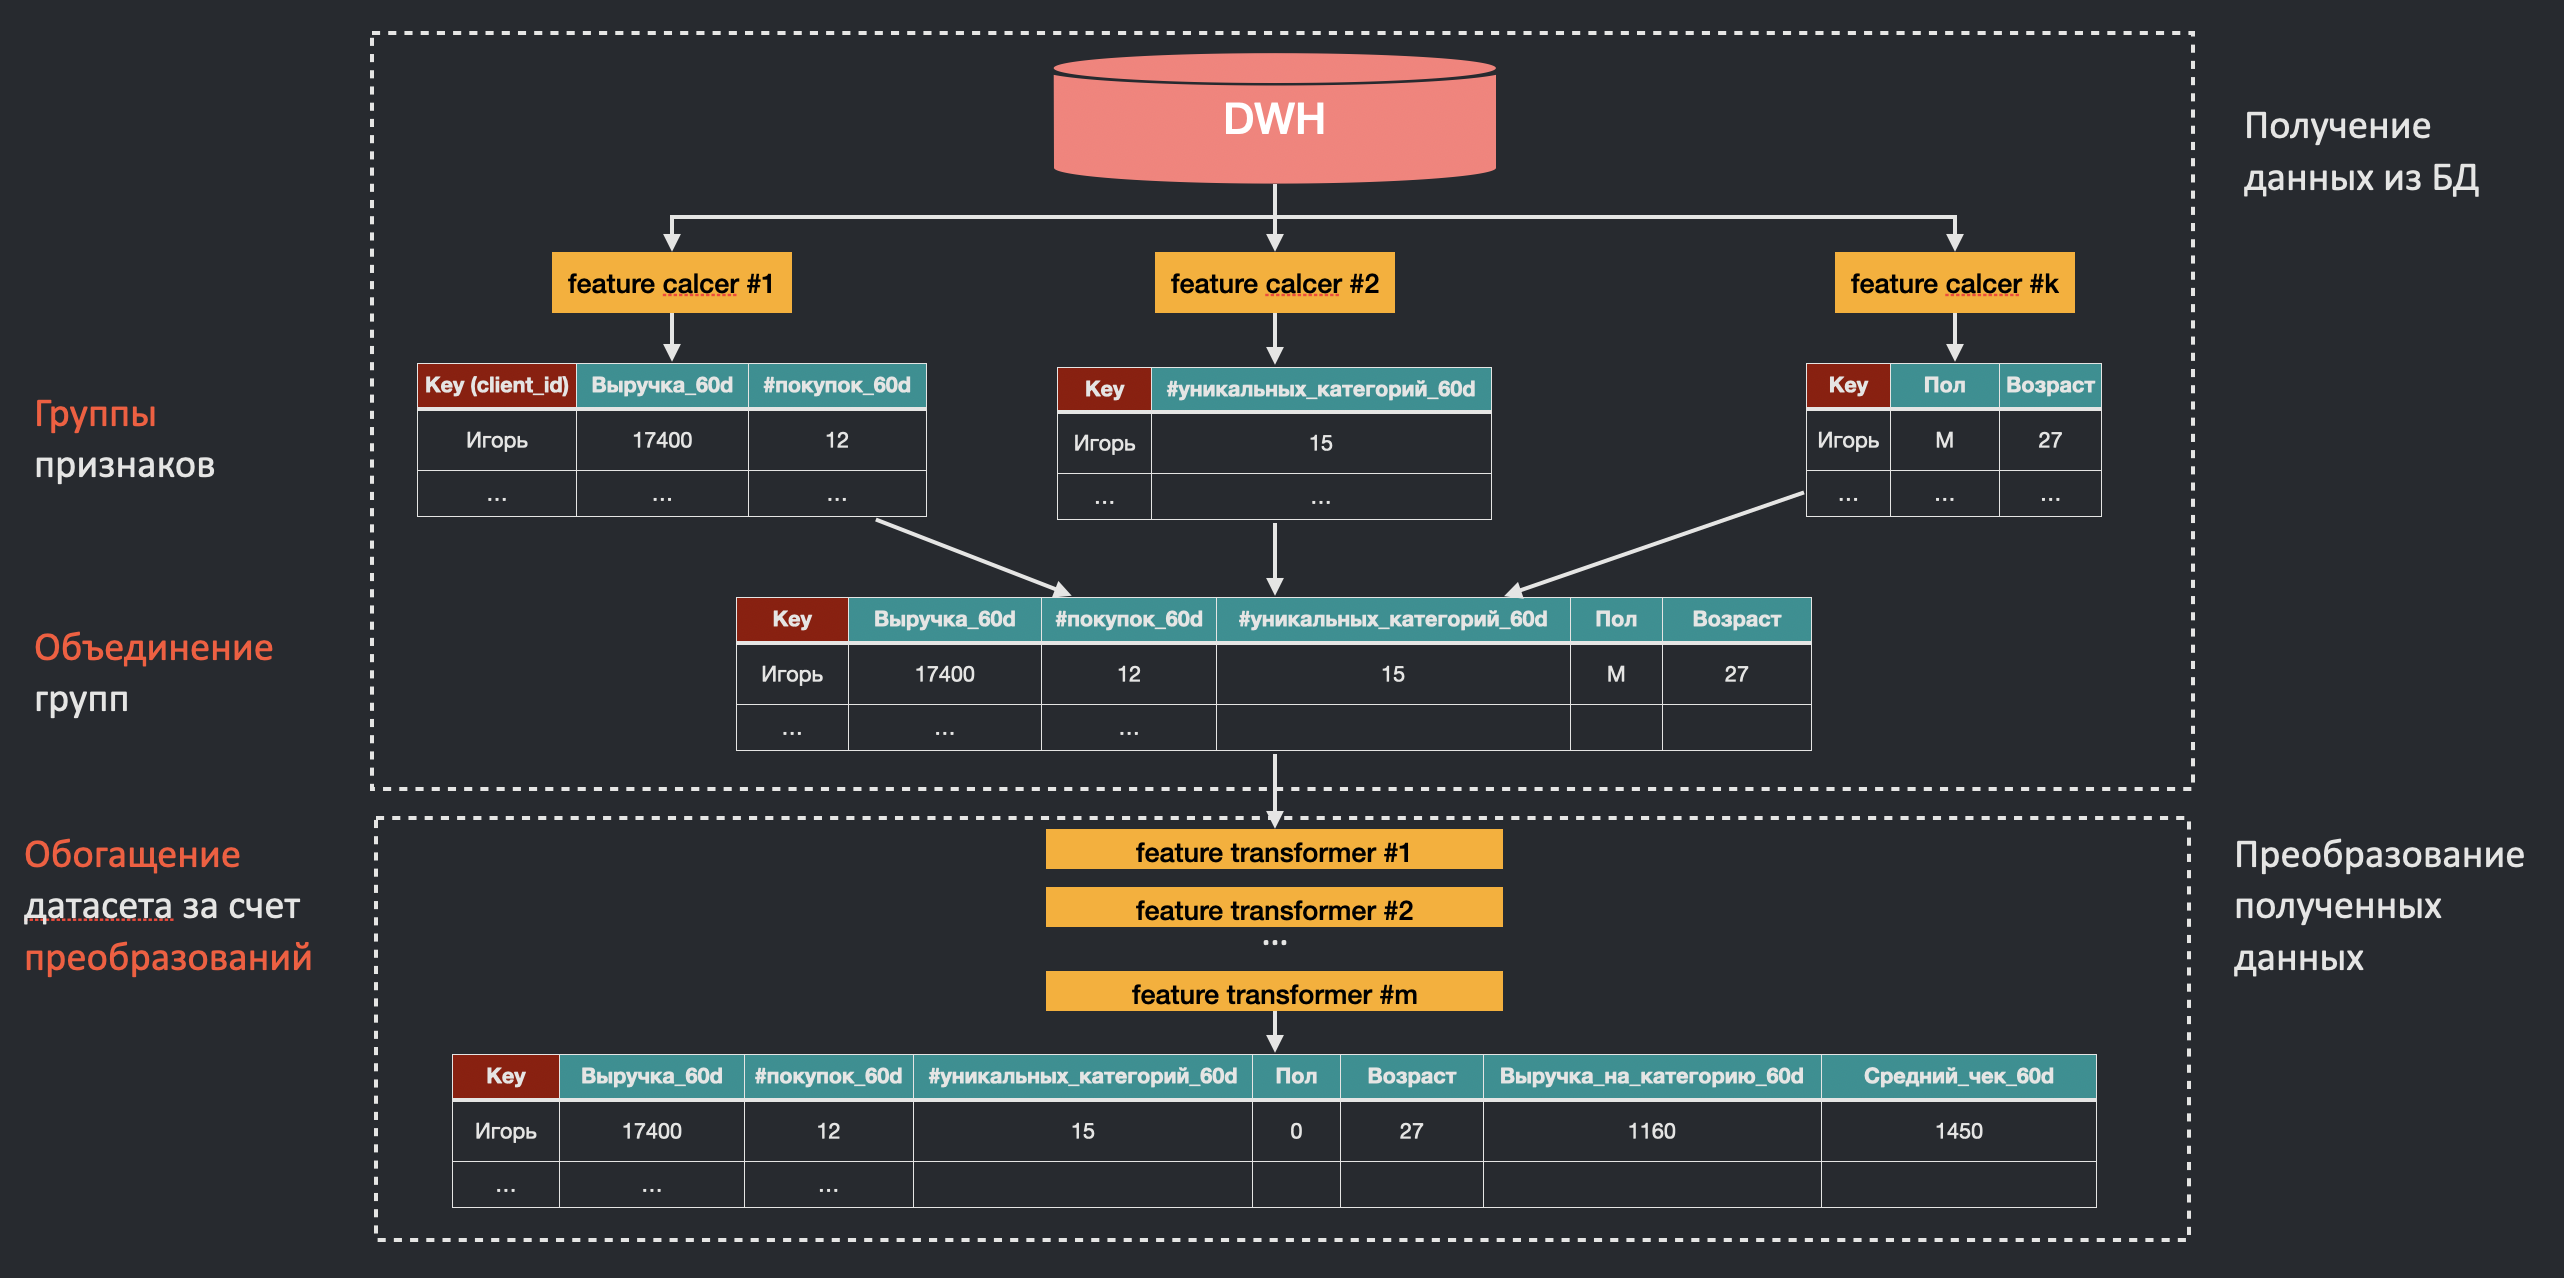

### Получение данных из БД

Хотим реализовать 3 группы признаков:

* Простые признаки на истории чеков - выручка, число чеков, средний чек, средний промежуток времени между покупками, ...
* Число уникальных категорий, которые покупал клиент.
* Соцдем признаки - пол и возраст

Договоримся о **формате скриптов расчета признаков**!

#### Базовый класс FeatureCalcer

In [12]:
from abc import ABC, abstractmethod


class FeatureCalcer(ABC):
    name = '_base'
    keys = None

    def __init__(self, engine: Engine):
        self.engine = engine

    @abstractmethod
    def compute(self):
        pass


class DateFeatureCalcer(FeatureCalcer):
    def __init__(self, date_to: datetime.date, **kwargs):
        self.date_to = date_to
        super().__init__(**kwargs)


#### Реализуем Calcer'ы

##### UniqueCategoriesCalcer

In [68]:
class UniqueCategoriesCalcer(DateFeatureCalcer):
    name = 'unique_categories'
    keys = ['client_id']

    def __init__(self, delta: int, col_category: str = 'level_3', **kwargs):
        self.delta = delta
        self.col_category = col_category
        super().__init__(**kwargs)

    def compute(self) -> dd.DataFrame:
        purchases = self.engine.get_table('purchases')
        products = self.engine.get_table('products')

        date_to = datetime.datetime.combine(self.date_to, datetime.datetime.min.time())
        date_from = date_to - datetime.timedelta(days=self.delta)
        date_mask = (purchases['transaction_datetime'] >= date_from) & (purchases['transaction_datetime'] < date_to)

        purchases = (
            purchases
            .loc[date_mask]
            .merge(
                products[['product_id', self.col_category]],
                on=['product_id'],
                how='inner'
            )
        )
        result = purchases.groupby(by=['client_id'])[self.col_category].nunique().reset_index()
        
        result = result.rename(columns={self.col_category: f'unique_{self.col_category}__{self.delta}d'})
        return result


# register_calcer(UniqueCategoriesCalcer)


In [71]:
calcer = UniqueCategoriesCalcer(
    engine=engine,
    col_category='level_3',
    delta=15,
    date_to=datetime.date(2019, 3, 19)
)

In [72]:
result = calcer.compute().compute()

In [73]:
result.shape

(443187, 2)

In [74]:
result.head()

,client_id,unique_level_3__15d
0,0,14
1,1,9
2,2,2
3,3,10
4,4,3


##### ReceiptsBasicFeatureCalcer

In [15]:
class ReceiptsBasicFeatureCalcer(DateFeatureCalcer):
    name = 'receipts_basic'
    keys = ['client_id']

    def __init__(self, delta: int, **kwargs):
        self.delta = delta
        super().__init__(**kwargs)

    def compute(self) -> dd.DataFrame:
        receipts = self.engine.get_table('receipts')

        date_to = datetime.datetime.combine(self.date_to, datetime.datetime.min.time())
        date_from = date_to - datetime.timedelta(days=self.delta)
        date_mask = (receipts['transaction_datetime'] >= date_from) & (receipts['transaction_datetime'] < date_to)

        features = (
            receipts
            .loc[date_mask]
            .assign(points_spent=lambda d: d['regular_points_spent'] + d['express_points_spent'])
            .assign(points_spent_flag=lambda d: (d['points_spent'] < 0).astype(int))
            .assign(express_points_spent_flag=lambda d: (d['express_points_spent'] < 0).astype(int))
        )
        features = dask_groupby(
            features,
            by=['client_id'],
            config={
                "transaction_id": "count",
                "purchase_sum": ["sum", "max", "min", "mean"],
                "regular_points_spent": ["sum", "max"],
                "express_points_spent": ["sum", "max"],
                "transaction_datetime": ["min", "max"],
                "trn_sum_from_red": ["sum", "max", "mean"],
                "points_spent_flag": ["sum"],
                "express_points_spent_flag": ["sum"],
            }
        )
        features = (
            features
            .assign(
                mean_time_interval=lambda d: (
                    (d['transaction_datetime_max'] - d['transaction_datetime_min'])
                    / (d['transaction_id_count'] - 1)
                ).apply(lambda delta: delta.total_seconds() / (24 * 3600))
            )
            .assign(
                time_since_last=lambda d: (
                    date_to - d['transaction_datetime_max']
                ).apply(lambda delta: delta.total_seconds() / (24 * 3600))
            )
        )

        features = features.reset_index()
        features = features.rename(columns={
            col: col + f'__{self.delta}d' for col in features.columns if col not in self.keys
        })

        return features


# register_calcer(ReceiptsBasicFeatureCalcer)


##### AgeGenderCalcer

In [84]:
class AgeGenderCalcer(FeatureCalcer):
    name = 'age_gender'
    keys = ['client_id']

    def compute(self) -> dd.DataFrame:
        client_profile = self.engine.get_table('client_profile')
        return client_profile[self.keys + ['age', 'gender']]


# register_calcer(AgeGenderCalcer)

#### Соберем результаты разных calcer'ов

Хотим получать датасет по конфигурации его расчета calcer'ами

Пример конфигурации:

In [82]:
config = [
    {
        'name': 'age_gender',
        'args': {}
    },
    {
        'name': 'unique_categories',
        'args': {
            'col_category': 'level_3',
            'delta': 60,
            'date_to': datetime.date(2019, 3, 19)
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'delta': 60,
            'date_to': datetime.date(2019, 3, 19)
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'delta': 30,
            'date_to': datetime.date(2019, 3, 19)
        }
    }
]

In [13]:
CALCER_REFERENCE = {}


def register_calcer(calcer_class) -> None:
    CALCER_REFERENCE[calcer_class.name] = calcer_class


def create_calcer(name: str, **kwargs) -> FeatureCalcer:
    return CALCER_REFERENCE[name](**kwargs)


In [ ]:
register_calcer(UniqueCategoriesCalcer)
register_calcer(ReceiptsBasicFeatureCalcer)
register_calcer(AgeGenderCalcer)

In [14]:
def join_tables(tables: List[dd.DataFrame], on: List[str], how: str) -> dd.DataFrame:
    result = tables[0]
    for table in tables[1: ]:
        result = result.merge(table, on=on, how=how)
    return result


def compute_features(engine: Engine, features_config: dict) -> dd.DataFrame:
    calcers = list()
    keys = None

    for feature_config in features_config:
        calcer_args = feature_config["args"]
        calcer_args["engine"] = engine

        calcer = create_calcer(feature_config["name"], **calcer_args)
        if keys is None:
            keys = set(calcer.keys)
        elif set(calcer.keys) != keys:
            raise KeyError(f"{calcer.keys}")

        calcers.append(calcer)

    computation_results = []
    for calcer in calcers:
        computation_results.append(calcer.compute())
    result = join_tables(computation_results, on=list(keys), how='outer')

    return result


Запустим расчет на части данных (чтобы посчиталось быстрее)

In [247]:
sample_tables = {
    'receipts': receipts_sample,
    'campaigns': campaigns_sample,
    'client_profile': client_profile_sample,
    'products': products,
    'purchases': purchases_sample,
}

sample_engine = Engine(tables=sample_tables)

In [248]:
config = [
    {
        'name': 'age_gender',
        'args': {}
    },
    {
        'name': 'unique_categories',
        'args': {
            'col_category': 'level_3',
            'delta': 60,
            'date_to': datetime.date(2019, 3, 19)
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'delta': 60,
            'date_to': datetime.date(2019, 3, 19)
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'delta': 30,
            'date_to': datetime.date(2019, 3, 19)
        }
    }
]

In [249]:
raw_features = compute_features(sample_engine, features_config=config)


You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))


You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('transaction_datetime_max', 'float64'))


You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silen

In [250]:
raw_features.columns

Index(['client_id', 'age', 'gender', 'unique_level_3__60d',
       'transaction_id_count__60d', 'purchase_sum_sum__60d',
       'purchase_sum_max__60d', 'purchase_sum_min__60d',
       'purchase_sum_mean__60d', 'regular_points_spent_sum__60d',
       'regular_points_spent_max__60d', 'express_points_spent_sum__60d',
       'express_points_spent_max__60d', 'transaction_datetime_min__60d',
       'transaction_datetime_max__60d', 'trn_sum_from_red_sum__60d',
       'trn_sum_from_red_max__60d', 'trn_sum_from_red_mean__60d',
       'points_spent_flag_sum__60d', 'express_points_spent_flag_sum__60d',
       'mean_time_interval__60d', 'time_since_last__60d',
       'transaction_id_count__30d', 'purchase_sum_sum__30d',
       'purchase_sum_max__30d', 'purchase_sum_min__30d',
       'purchase_sum_mean__30d', 'regular_points_spent_sum__30d',
       'regular_points_spent_max__30d', 'express_points_spent_sum__30d',
       'express_points_spent_max__30d', 'transaction_datetime_min__30d',
       'tran

In [251]:
type(raw_features)

dask.dataframe.core.DataFrame

In [252]:
raw_features = raw_features.compute()

In [253]:
type(raw_features)

pandas.core.frame.DataFrame

In [90]:
raw_features.shape

(10000, 40)

In [254]:
raw_features.sample(20)

,client_id,age,gender,unique_level_3__60d,transaction_id_count__60d,purchase_sum_sum__60d,purchase_sum_max__60d,purchase_sum_min__60d,purchase_sum_mean__60d,regular_points_spent_sum__60d,...,express_points_spent_max__30d,transaction_datetime_min__30d,transaction_datetime_max__30d,trn_sum_from_red_sum__30d,trn_sum_from_red_max__30d,trn_sum_from_red_mean__30d,points_spent_flag_sum__30d,express_points_spent_flag_sum__30d,mean_time_interval__30d,time_since_last__30d
3935,485242,66,F,1.0,34,1759.00,268.00,38.00,51.735294,0.0,...,0.0,2019-02-17 17:05:57,2019-03-17 15:05:27,0.0,0.0,0.000000,0,0,1.642136,1.371215
9315,281620,25,U,46.0,25,8806.96,900.00,49.00,352.278400,-101.0,...,0.0,2019-02-18 13:30:59,2019-03-17 17:58:56,299.0,299.0,23.000000,1,0,2.265506,1.250741
8825,324127,15,F,5.0,4,907.60,384.00,109.99,226.900000,0.0,...,0.0,2019-02-20 06:45:32,2019-03-11 07:08:04,0.0,0.0,0.000000,0,0,19.015648,7.702731
3926,132448,53,F,29.0,10,5073.44,763.00,235.45,507.344000,0.0,...,0.0,2019-02-18 06:30:51,2019-03-12 09:43:30,0.0,0.0,0.000000,0,0,4.426757,6.594792
2642,374390,19,M,27.0,44,9849.70,515.00,32.99,223.856818,-37.0,...,0.0,2019-02-18 08:32:49,2019-03-18 13:19:18,515.0,515.0,22.391304,1,0,1.281770,0.444931
9318,248652,38,U,40.0,9,11740.78,2344.00,78.00,1304.531111,-212.0,...,0.0,2019-02-22 15:44:23,2019-03-16 08:21:26,738.0,659.0,105.428571,2,0,3.615399,2.651782
1116,370703,19,M,26.0,15,3100.30,761.00,26.78,206.686667,0.0,...,0.0,2019-02-26 11:30:16,2019-03-18 16:56:10,0.0,0.0,0.000000,0,0,1.555871,0.294329
1876,235568,25,M,32.0,9,5500.00,1452.00,209.00,611.111111,0.0,...,0.0,2019-03-03 01:03:49,2019-03-08 09:32:11,0.0,0.0,0.000000,0,0,1.784344,10.602650
4998,173818,77,M,15.0,2,1580.00,907.00,673.00,790.000000,0.0,...,0.0,2019-03-15 16:04:22,2019-03-15 16:04:22,0.0,0.0,0.000000,0,0,NaN,3.330301
6672,131237,22,U,10.0,7,1134.43,396.97,47.34,162.061429,0.0,...,0.0,2019-02-25 17:11:12,2019-03-10 11:08:06,0.0,0.0,0.000000,0,0,3.186962,8.536042


### Преобразование данных

Посмотрим на некоторые уже посчитанные признаки

In [135]:
raw_features[[
    'client_id',
    'unique_level_3__60d',
    'purchase_sum_sum__60d',
    'mean_time_interval__60d',
    'time_since_last__60d',
    'gender'
]].sample(8)

,client_id,unique_level_3__60d,purchase_sum_sum__60d,mean_time_interval__60d,time_since_last__60d,gender
3741,169969,8.0,548.53,32.378785,5.329479,M
7776,228229,26.0,4079.77,15.941057,10.631736,U
7661,422943,32.0,5480.00,6.995815,0.631400,F
9217,255585,4.0,351.00,NaN,9.711863,U
8716,475275,28.0,7700.28,6.015123,0.360972,F
4511,339259,15.0,4322.00,3.287812,11.451586,M
6430,424511,13.0,2338.00,9.272512,14.376944,U
5389,5731,37.0,5103.13,2.920508,1.355405,F


Хотим также добавить в наш датасет новые признаки
1. средняя выручка на одну категорию: purchase_sum_sum__60d / unique_level_3__60d
2. во сколько время с последней покупки больше среднего интервала покупок клиента: time_since_last__60d / mean_time_interval__60d
3. one hot encoding для колонки с полом

Как лучше это сделать? Может быть подправить калкеры?

**(3)** Не всем пользователям калкера AgeGenderCalcer нужен пол, приведенный к OHE формату

**(1)** Считается на признаках из разных групп (калкеров) - не получится реализовать, подправив калкеры.ь

Нужно продумать преобразование данных!

#### Как организуем преобразование данных?

Будем выстраивать преобразования данных в очередь. Построим pipeline преобразований.

Для этого удобно использовать Pipeline из библиотеки scikit-learn (см. https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)


<div>
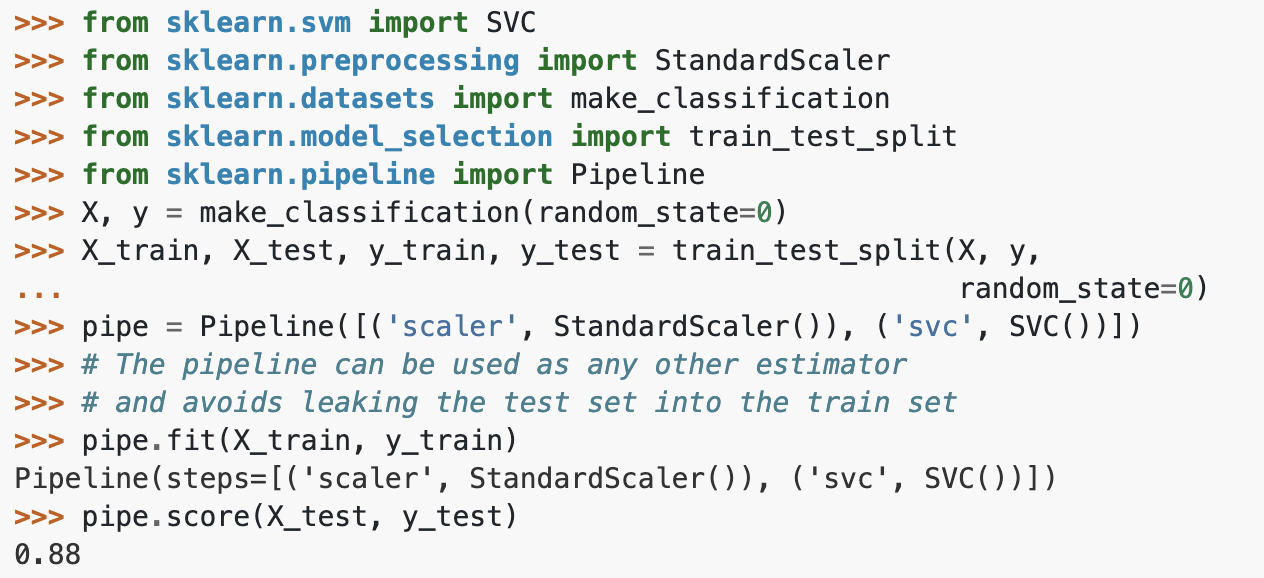
</div>

Каждый шаг пайплайна должен быть объектом, у которого определены 2 метода:

* fit(self, X, y=None)
* transform(self, X, y=None)

Будем наследовать наши преобразования от класса BaseEstimator

In [255]:
import sklearn.base as skbase
import sklearn.pipeline as skpipe

#### Реализуем Transformer'ы

##### OneHotEncoder

In [257]:
import sklearn.preprocessing as skpreprocessing


class OneHotEncoder(skbase.BaseEstimator):

    def __init__(self, cols: List[str], prefix: str = 'ohe', **ohe_params):
        self.cols = cols
        self.prefix = prefix
        self.encoder_ = skpreprocessing.OneHotEncoder(**(ohe_params or {}))

    def fit(self, data: pd.DataFrame, *args, **kwargs):
        self.encoder_.fit(data[self.cols])
        return self

    def transform(self, data: pd.DataFrame, *args, **kwargs) -> pd.DataFrame:
        result_column_names = []
        for col_idx, col in enumerate(self.cols):
            result_column_names += [
                f'{self.prefix}__{col}__{value}'
                for i, value in enumerate(self.encoder_.categories_[col_idx])
                if self.encoder_.drop_idx_ is None or i != self.encoder_.drop_idx_[col_idx]
            ]

        encoded = pd.DataFrame(
            self.encoder_.transform(data[self.cols]).todense(),
            columns=result_column_names
        )

        for col in encoded.columns:
            data[col] = encoded[col]
        return data


# register_transformer(OneHotEncoder, 'one_hot_encoder')

In [259]:
transformer = OneHotEncoder(cols=['gender'], prefix='ohe')

In [262]:
transformer.fit(raw_features)

OneHotEncoder(cols=['gender'])

In [263]:
tmp = transformer.transform(raw_features.copy())

In [264]:
tmp.head()

,client_id,age,gender,unique_level_3__60d,transaction_id_count__60d,purchase_sum_sum__60d,purchase_sum_max__60d,purchase_sum_min__60d,purchase_sum_mean__60d,regular_points_spent_sum__60d,...,trn_sum_from_red_sum__30d,trn_sum_from_red_max__30d,trn_sum_from_red_mean__30d,points_spent_flag_sum__30d,express_points_spent_flag_sum__30d,mean_time_interval__30d,time_since_last__30d,ohe__gender__F,ohe__gender__M,ohe__gender__U
0,444202,55,F,32.0,12,21333.69,3435.00,893.85,1777.807500,-231.0,...,1589.0,1589.0,794.500000,1,0,0.965868,3.503113,1.0,0.0,0.0
1,379483,59,F,38.0,6,5939.74,3302.10,123.79,989.956667,0.0,...,0.0,0.0,0.000000,0,0,3.249687,4.329711,1.0,0.0,0.0
2,243847,38,F,21.0,4,2117.00,864.00,355.00,529.250000,-16.0,...,0.0,0.0,0.000000,0,0,11.485150,2.534144,1.0,0.0,0.0
3,93011,39,U,37.0,22,7746.06,1038.00,58.48,352.093636,-43.0,...,1202.0,634.0,100.166667,3,0,2.660913,0.444850,0.0,0.0,1.0
4,313449,64,U,34.0,6,10857.22,2594.94,1251.84,1809.536667,0.0,...,0.0,0.0,0.000000,0,0,10.839965,9.683449,0.0,0.0,1.0


In [221]:
transformer = OneHotEncoder(cols=['gender'], prefix='ohue', drop='first')

In [222]:
transformer.fit(raw_features)

OneHotEncoder(cols=['gender'], prefix='ohue')

In [223]:
tmp = transformer.transform(raw_features.copy())

In [224]:
tmp.head()

,client_id,age,gender,unique_level_3__60d,transaction_id_count__60d,purchase_sum_sum__60d,purchase_sum_max__60d,purchase_sum_min__60d,purchase_sum_mean__60d,regular_points_spent_sum__60d,...,transaction_datetime_max__30d,trn_sum_from_red_sum__30d,trn_sum_from_red_max__30d,trn_sum_from_red_mean__30d,points_spent_flag_sum__30d,express_points_spent_flag_sum__30d,mean_time_interval__30d,time_since_last__30d,ohue__gender__M,ohue__gender__U
0,444202,55,F,32.0,12,21333.69,3435.00,893.85,1777.807500,-231.0,...,2019-03-15 11:55:31,1589.0,1589.0,794.500000,1,0,0.965868,3.503113,0.0,0.0
1,379483,59,F,38.0,6,5939.74,3302.10,123.79,989.956667,0.0,...,2019-03-14 16:05:13,0.0,0.0,0.000000,0,0,3.249687,4.329711,0.0,0.0
2,243847,38,F,21.0,4,2117.00,864.00,355.00,529.250000,-16.0,...,2019-03-16 11:10:50,0.0,0.0,0.000000,0,0,11.485150,2.534144,0.0,0.0
3,93011,39,U,37.0,22,7746.06,1038.00,58.48,352.093636,-43.0,...,2019-03-18 13:19:25,1202.0,634.0,100.166667,3,0,2.660913,0.444850,0.0,1.0
4,313449,64,U,34.0,6,10857.22,2594.94,1251.84,1809.536667,0.0,...,2019-03-09 07:35:50,0.0,0.0,0.000000,0,0,10.839965,9.683449,0.0,1.0


##### divide_cols

In [265]:
def _divide_cols(data: pd.DataFrame, col_numerator: str, col_denominator: str, col_result: str = None):
    col_result = col_result or f'ratio__{col_numerator}__{col_denominator}'
    data[col_result] = data[col_numerator] / data[col_denominator]
    return data

In [266]:
_divide_cols(raw_features.copy(), col_numerator='purchase_sum_sum__60d', col_denominator='unique_level_3__60d').head()

,client_id,age,gender,unique_level_3__60d,transaction_id_count__60d,purchase_sum_sum__60d,purchase_sum_max__60d,purchase_sum_min__60d,purchase_sum_mean__60d,regular_points_spent_sum__60d,...,transaction_datetime_min__30d,transaction_datetime_max__30d,trn_sum_from_red_sum__30d,trn_sum_from_red_max__30d,trn_sum_from_red_mean__30d,points_spent_flag_sum__30d,express_points_spent_flag_sum__30d,mean_time_interval__30d,time_since_last__30d,ratio__purchase_sum_sum__60d__unique_level_3__60d
0,444202,55,F,32.0,12,21333.69,3435.00,893.85,1777.807500,-231.0,...,2019-03-14 12:44:40,2019-03-15 11:55:31,1589.0,1589.0,794.500000,1,0,0.965868,3.503113,666.677812
1,379483,59,F,38.0,6,5939.74,3302.10,123.79,989.956667,0.0,...,2019-03-01 16:07:01,2019-03-14 16:05:13,0.0,0.0,0.000000,0,0,3.249687,4.329711,156.308947
2,243847,38,F,21.0,4,2117.00,864.00,355.00,529.250000,-16.0,...,2019-02-21 11:53:36,2019-03-16 11:10:50,0.0,0.0,0.000000,0,0,11.485150,2.534144,100.809524
3,93011,39,U,37.0,22,7746.06,1038.00,58.48,352.093636,-43.0,...,2019-02-17 06:50:33,2019-03-18 13:19:25,1202.0,634.0,100.166667,3,0,2.660913,0.444850,209.352973
4,313449,64,U,34.0,6,10857.22,2594.94,1251.84,1809.536667,0.0,...,2019-02-26 11:26:17,2019-03-09 07:35:50,0.0,0.0,0.000000,0,0,10.839965,9.683449,319.330000


Как привести функцию к формату, необходимому для пайплайна? Напишем обертку

In [97]:
import functools


class FunctionalTransformer(skbase.BaseEstimator):

    def __init__(self, function, **params):
        self.function = functools.partial(function, **params)

    def fit(self, *args, **kwargs):
        return self

    def transform(self, *args, **kwargs):
        return self.function(*args, **kwargs)


In [267]:
transformer = FunctionalTransformer(
    function=_divide_cols,
    col_numerator='purchase_sum_sum__60d',
    col_denominator='unique_level_3__60d',
    col_result='purchase_sum_per_category_level_3__60d'
)

In [269]:
transformer.transform(raw_features.copy()).head()

,client_id,age,gender,unique_level_3__60d,transaction_id_count__60d,purchase_sum_sum__60d,purchase_sum_max__60d,purchase_sum_min__60d,purchase_sum_mean__60d,regular_points_spent_sum__60d,...,transaction_datetime_min__30d,transaction_datetime_max__30d,trn_sum_from_red_sum__30d,trn_sum_from_red_max__30d,trn_sum_from_red_mean__30d,points_spent_flag_sum__30d,express_points_spent_flag_sum__30d,mean_time_interval__30d,time_since_last__30d,purchase_sum_per_category_level_3__60d
0,444202,55,F,32.0,12,21333.69,3435.00,893.85,1777.807500,-231.0,...,2019-03-14 12:44:40,2019-03-15 11:55:31,1589.0,1589.0,794.500000,1,0,0.965868,3.503113,666.677812
1,379483,59,F,38.0,6,5939.74,3302.10,123.79,989.956667,0.0,...,2019-03-01 16:07:01,2019-03-14 16:05:13,0.0,0.0,0.000000,0,0,3.249687,4.329711,156.308947
2,243847,38,F,21.0,4,2117.00,864.00,355.00,529.250000,-16.0,...,2019-02-21 11:53:36,2019-03-16 11:10:50,0.0,0.0,0.000000,0,0,11.485150,2.534144,100.809524
3,93011,39,U,37.0,22,7746.06,1038.00,58.48,352.093636,-43.0,...,2019-02-17 06:50:33,2019-03-18 13:19:25,1202.0,634.0,100.166667,3,0,2.660913,0.444850,209.352973
4,313449,64,U,34.0,6,10857.22,2594.94,1251.84,1809.536667,0.0,...,2019-02-26 11:26:17,2019-03-09 07:35:50,0.0,0.0,0.000000,0,0,10.839965,9.683449,319.330000


Уже хорошо. Но сделаем еще элегантнее. Реализуем декоратор

In [98]:
def functional_transformer(function):
    def builder(**params):
        return FunctionalTransformer(function, **params)
    return builder

In [100]:
@functional_transformer
def divide_cols(data: pd.DataFrame, col_numerator: str, col_denominator: str, col_result: str = None):
    col_result = col_result or f'ratio__{col_numerator}__{col_denominator}'
    data[col_result] = data[col_numerator] / data[col_denominator]
    return data


# register_transformer(divide_cols, 'divide')

Проверим

In [270]:
transformer = divide_cols(
    col_numerator='purchase_sum_sum__60d',
    col_denominator='unique_level_3__60d',
    col_result='purchase_sum_per_category_level_3__60d'
)

In [271]:
type(transformer)

__main__.FunctionalTransformer

In [227]:
transformer.transform(raw_features.copy()).head()

,client_id,age,gender,unique_level_3__60d,transaction_id_count__60d,purchase_sum_sum__60d,purchase_sum_max__60d,purchase_sum_min__60d,purchase_sum_mean__60d,regular_points_spent_sum__60d,...,transaction_datetime_min__30d,transaction_datetime_max__30d,trn_sum_from_red_sum__30d,trn_sum_from_red_max__30d,trn_sum_from_red_mean__30d,points_spent_flag_sum__30d,express_points_spent_flag_sum__30d,mean_time_interval__30d,time_since_last__30d,ratio__purchase_sum_sum__60d__unique_level_3__60d
0,444202,55,F,32.0,12,21333.69,3435.00,893.85,1777.807500,-231.0,...,2019-03-14 12:44:40,2019-03-15 11:55:31,1589.0,1589.0,794.500000,1,0,0.965868,3.503113,666.677812
1,379483,59,F,38.0,6,5939.74,3302.10,123.79,989.956667,0.0,...,2019-03-01 16:07:01,2019-03-14 16:05:13,0.0,0.0,0.000000,0,0,3.249687,4.329711,156.308947
2,243847,38,F,21.0,4,2117.00,864.00,355.00,529.250000,-16.0,...,2019-02-21 11:53:36,2019-03-16 11:10:50,0.0,0.0,0.000000,0,0,11.485150,2.534144,100.809524
3,93011,39,U,37.0,22,7746.06,1038.00,58.48,352.093636,-43.0,...,2019-02-17 06:50:33,2019-03-18 13:19:25,1202.0,634.0,100.166667,3,0,2.660913,0.444850,209.352973
4,313449,64,U,34.0,6,10857.22,2594.94,1251.84,1809.536667,0.0,...,2019-02-26 11:26:17,2019-03-09 07:35:50,0.0,0.0,0.000000,0,0,10.839965,9.683449,319.330000


#### Соберем итоговый pipeline

In [236]:
transform_config = [
    {
        'name': 'divide',
        'args': {
            'col_numerator': 'purchase_sum_sum__60d',
            'col_denominator': 'unique_level_3__60d',
            'col_result': 'purchase_sum_per_category_level_3__60d'
        }
    },
    {
        'name': 'divide',
        'args': {
            'col_numerator': 'time_since_last__60d',
            'col_denominator': 'mean_time_interval__60d',
            'col_result': 'ratio__time_since_last__mean_interval__60d'
        }
    },
    {
        'name': 'one_hot_encoder',
        'args': {
            'cols': ['gender'],
        }
    },
    
]

In [272]:
TRANSFORMER_REFERENCE = {}


def register_transformer(transformer_class, name: str) -> None:
    TRANSFORMER_REFERENCE[name] = transformer_class


def create_transformer(name: str, **kwargs) -> skbase.BaseEstimator:
    return TRANSFORMER_REFERENCE[name](**kwargs)


In [273]:
register_transformer(OneHotEncoder, 'one_hot_encoder')
register_transformer(divide_cols, 'divide')

In [275]:
def build_pipeline(transform_config: dict) -> skpipe.Pipeline:
    transformers = list()

    for i, transformer_config in enumerate(transform_config):
        transformer_args = transformer_config["args"]

        transformer = create_transformer(transformer_config["name"], **transformer_args)
        uname = transformer_config.get("uname", f'stage_{i}')
        
        transformers.append((uname, transformer))
    
    pipeline = skpipe.Pipeline(transformers)
    return pipeline


In [276]:
pipeline = build_pipeline(transform_config)

In [278]:
features = pipeline.fit_transform(raw_features.copy())

In [279]:
features.sample(20)

,client_id,age,gender,unique_level_3__60d,transaction_id_count__60d,purchase_sum_sum__60d,purchase_sum_max__60d,purchase_sum_min__60d,purchase_sum_mean__60d,regular_points_spent_sum__60d,...,trn_sum_from_red_mean__30d,points_spent_flag_sum__30d,express_points_spent_flag_sum__30d,mean_time_interval__30d,time_since_last__30d,purchase_sum_per_category_level_3__60d,ratio__time_since_last__mean_interval__60d,ohe__gender__F,ohe__gender__M,ohe__gender__U
227,51825,27,F,34.0,27,10784.77,1389.73,59.00,399.435926,-82.0,...,5.944444,1,0,1.639907,0.588843,317.199118,0.259058,1.0,0.0,0.0
4938,88937,69,U,43.0,30,10333.04,1074.05,22.00,344.434667,-29.0,...,0.000000,0,0,1.790843,2.630822,240.303256,1.465868,0.0,0.0,1.0
8582,413052,35,M,46.0,36,14114.38,1490.00,49.00,392.066111,-168.0,...,36.833333,1,0,3.644856,3.210671,306.834348,2.001105,0.0,1.0,0.0
7367,132983,44,U,17.0,5,2239.89,1174.00,161.00,447.978000,-23.0,...,0.000000,0,0,NaN,14.656505,131.758235,1.368956,0.0,0.0,1.0
3996,199568,68,F,32.0,13,6600.69,997.00,170.00,507.745385,-118.0,...,78.777778,1,0,3.482668,0.688796,206.271562,0.141105,1.0,0.0,0.0
4517,1632,62,U,33.0,23,5545.00,580.00,39.00,241.086957,0.0,...,0.000000,0,0,2.636175,0.590671,168.030303,0.232072,0.0,0.0,1.0
332,77495,59,U,39.0,14,8297.38,1558.72,101.64,592.670000,-157.0,...,68.375000,1,0,3.523757,3.701528,212.753333,1.051279,0.0,0.0,1.0
2158,111834,54,U,5.0,3,424.71,187.29,114.42,141.570000,0.0,...,0.000000,0,0,17.041481,10.525324,84.942000,0.999454,0.0,0.0,1.0
4668,454035,66,U,12.0,2,574.00,374.00,200.00,287.000000,-24.0,...,0.000000,0,0,NaN,15.465694,47.833333,0.856172,0.0,0.0,1.0
2036,462343,16,F,26.0,11,1885.89,342.00,56.16,171.444545,0.0,...,0.000000,0,0,3.168810,7.286655,72.534231,2.702573,1.0,0.0,0.0


## Library

Соберем написанные выше скрипты

### calcers

#### core

In [ ]:
from abc import ABC, abstractmethod


class FeatureCalcer(ABC):
    name = '_base'
    keys = None

    def __init__(self, engine: Engine):
        self.engine = engine

    @abstractmethod
    def compute(self):
        pass


class DateFeatureCalcer(FeatureCalcer):
    def __init__(self, date_to: datetime.date, **kwargs):
        self.date_to = date_to
        super().__init__(**kwargs)


CALCER_REFERENCE = {}


def register_calcer(calcer_class) -> None:
    CALCER_REFERENCE[calcer_class.name] = calcer_class


def create_calcer(name: str, **kwargs) -> FeatureCalcer:
    return CALCER_REFERENCE[name](**kwargs)


def join_tables(tables: List[dd.DataFrame], on: List[str], how: str) -> dd.DataFrame:
    result = tables[0]
    for table in tables[1: ]:
        result = result.merge(table, on=on, how=how)
    return result


def compute_features(engine: Engine, features_config: dict) -> dd.DataFrame:
    calcers = list()
    keys = None

    for feature_config in features_config:
        calcer_args = feature_config["args"]
        calcer_args["engine"] = engine

        calcer = create_calcer(feature_config["name"], **calcer_args)
        if keys is None:
            keys = set(calcer.keys)
        elif set(calcer.keys) != keys:
            raise KeyError(f"{calcer.keys}")

        calcers.append(calcer)

    computation_results = []
    for calcer in calcers:
        computation_results.append(calcer.compute())
    result = join_tables(computation_results, on=list(keys), how='outer')

    return result


#### implementations

In [ ]:
class UniqueCategoriesCalcer(DateFeatureCalcer):
    name = 'unique_categories'
    keys = ['client_id']

    def __init__(self, delta: int, col_category: str = 'level_3', **kwargs):
        self.delta = delta
        self.col_category = col_category
        super().__init__(**kwargs)

    def compute(self) -> dd.DataFrame:
        purchases = self.engine.get_table('purchases')
        products = self.engine.get_table('products')

        date_to = datetime.datetime.combine(self.date_to, datetime.datetime.min.time())
        date_from = date_to - datetime.timedelta(days=self.delta)
        date_mask = (purchases['transaction_datetime'] >= date_from) & (purchases['transaction_datetime'] < date_to)

        purchases = (
            purchases
            .loc[date_mask]
            .merge(
                products[['product_id', self.col_category]],
                on=['product_id'],
                how='inner'
            )
        )
        result = purchases.groupby(by=['client_id'])[self.col_category].nunique().reset_index()
        
        result = result.rename(columns={self.col_category: f'unique_{self.col_category}__{self.delta}d'})
        return result


register_calcer(UniqueCategoriesCalcer)


In [15]:
class ReceiptsBasicFeatureCalcer(DateFeatureCalcer):
    name = 'receipts_basic'
    keys = ['client_id']

    def __init__(self, delta: int, **kwargs):
        self.delta = delta
        super().__init__(**kwargs)

    def compute(self) -> dd.DataFrame:
        receipts = self.engine.get_table('receipts')

        date_to = datetime.datetime.combine(self.date_to, datetime.datetime.min.time())
        date_from = date_to - datetime.timedelta(days=self.delta)
        date_mask = (receipts['transaction_datetime'] >= date_from) & (receipts['transaction_datetime'] < date_to)

        features = (
            receipts
            .loc[date_mask]
            .assign(points_spent=lambda d: d['regular_points_spent'] + d['express_points_spent'])
            .assign(points_spent_flag=lambda d: (d['points_spent'] < 0).astype(int))
            .assign(express_points_spent_flag=lambda d: (d['express_points_spent'] < 0).astype(int))
        )
        features = dask_groupby(
            features,
            by=['client_id'],
            config={
                "transaction_id": "count",
                "purchase_sum": ["sum", "max", "min", "mean"],
                "regular_points_spent": ["sum", "max"],
                "express_points_spent": ["sum", "max"],
                "transaction_datetime": ["min", "max"],
                "trn_sum_from_red": ["sum", "max", "mean"],
                "points_spent_flag": ["sum"],
                "express_points_spent_flag": ["sum"],
            }
        )
        features = (
            features
            .assign(
                mean_time_interval=lambda d: (
                    (d['transaction_datetime_max'] - d['transaction_datetime_min'])
                    / (d['transaction_id_count'] - 1)
                ).apply(lambda delta: delta.total_seconds() / (24 * 3600))
            )
            .assign(
                time_since_last=lambda d: (
                    date_to - d['transaction_datetime_max']
                ).apply(lambda delta: delta.total_seconds() / (24 * 3600))
            )
        )

        features = features.reset_index()
        features = features.rename(columns={
            col: col + f'__{self.delta}d' for col in features.columns if col not in self.keys
        })

        return features


register_calcer(ReceiptsBasicFeatureCalcer)


In [84]:
class AgeGenderCalcer(FeatureCalcer):
    name = 'age_gender'
    keys = ['client_id']

    def compute(self) -> dd.DataFrame:
        client_profile = self.engine.get_table('client_profile')
        return client_profile[self.keys + ['age', 'gender']]


register_calcer(AgeGenderCalcer)

### transforms

#### core

In [ ]:
import sklearn.base as skbase
import sklearn.pipeline as skpipe
import functools


class FunctionalTransformer(skbase.BaseEstimator):

    def __init__(self, function, **params):
        self.function = functools.partial(function, **params)

    def fit(self, *args, **kwargs):
        return self

    def transform(self, *args, **kwargs):
        return self.function(*args, **kwargs)


def functional_transformer(function):
    def builder(**params):
        return FunctionalTransformer(function, **params)
    return builder


TRANSFORMER_REFERENCE = {}


def register_transformer(transformer_class, name: str) -> None:
    TRANSFORMER_REFERENCE[name] = transformer_class


def create_transformer(name: str, **kwargs) -> skbase.BaseEstimator:
    return TRANSFORMER_REFERENCE[name](**kwargs)


def build_pipeline(transform_config: dict) -> skpipe.Pipeline:
    transformers = list()

    for i, transformer_config in enumerate(transform_config):
        transformer_args = transformer_config["args"]

        transformer = create_transformer(transformer_config["name"], **transformer_args)
        uname = transformer_config.get("uname", f'stage_{i}')
        
        transformers.append((uname, transformer))
    
    pipeline = skpipe.Pipeline(transformers)
    return pipeline


#### implementations

In [100]:
@functional_transformer
def divide_cols(data: pd.DataFrame, col_numerator: str, col_denominator: str, col_result: str = None):
    col_result = col_result or f'ratio__{col_numerator}__{col_denominator}'
    data[col_result] = data[col_numerator] / data[col_denominator]
    return data


register_transformer(divide_cols, 'divide')

In [211]:
import sklearn.preprocessing as skpreprocessing


class OneHotEncoder(skbase.BaseEstimator):

    def __init__(self, cols: List[str], prefix: str = 'ohe', **ohe_params):
        self.cols = cols
        self.prefix = prefix
        self.encoder_ = skpreprocessing.OneHotEncoder(**(ohe_params or {}))

    def fit(self, data: pd.DataFrame, *args, **kwargs):
        self.encoder_.fit(data[self.cols])
        return self

    def transform(self, data: pd.DataFrame, *args, **kwargs) -> pd.DataFrame:
        result_column_names = []
        for col_idx, col in enumerate(self.cols):
            result_column_names += [
                f'{self.prefix}__{col}__{value}'
                for i, value in enumerate(self.encoder_.categories_[col_idx])
                if self.encoder_.drop_idx_ is None or i != self.encoder_.drop_idx_[col_idx]
            ]

        encoded = pd.DataFrame(
            self.encoder_.transform(data[self.cols]).todense(),
            columns=result_column_names
        )

        for col in encoded.columns:
            data[col] = encoded[col]
        return data


# register_transformer(OneHotEncoder, 'one_hot_encoder')